<a href="https://colab.research.google.com/github/MoJaeYoung/first-repository/blob/master/%5BE_8%5D_%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84%EC%9D%84_%EB%A7%8C%EB%93%A4%EC%96%B4_%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 인물모드 직접 해 보기



## 1. 사진을 준비하자

In [ ]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

(800, 600, 3)
(800, 600, 3)
(800, 600, 3)


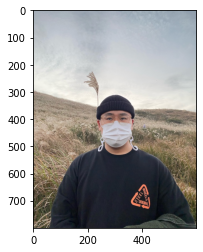

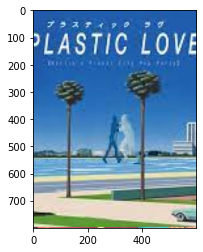

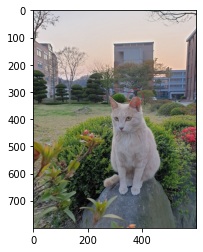

In [ ]:
import os

#본인
img_path = '/content/drive/MyDrive/Colab_Notebooks/datasethuman_segmentation/images/mo3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)


#배경
img_path = '/content/drive/MyDrive/Colab_Notebooks/datasethuman_segmentation/images/moback.jpg'  # 배경 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_back = cv2.imread(img_path) 
print (img_back.shape)


#고양이
img_path = '/content/drive/MyDrive/Colab_Notebooks/datasethuman_segmentation/images/cat.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path) 
print (img_back.shape)

#pc = [img_orig]
#pc2 = [img_cat]

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))
plt.show()


plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 세그멘테이션으로 사람 분리하기
>> 1.  DeepLabModel 클래스를 만들기


In [ ]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

>> 2. 사전에 학습된 가중치(pretrained weight)를 불러옴

In [ ]:
#사전에 학습된 가중치(pretrained weight)를 불러오기

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)
    
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /root/aiffel/human_segmentation/models
model loaded successfully!


>> 3. 첫 단계에서 준비한 이미지를 네트워크에 입력

In [ ]:
def InputNetwork(orig_img):

    img_resized, seg_map = MODEL.run(orig_img)
    print (orig_img.shape, img_resized.shape, seg_map.max())
    # cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시
    print("\n\n")

    return img_resized, seg_map

img_resized, seg_map = InputNetwork(img_orig)

(800, 600, 3) (513, 384, 3) 15





In [ ]:
# 라벨 종류

LABEL_NAMES = [ #7 , 15 , 21
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

>> 4. 마스크를 만들고 시각화

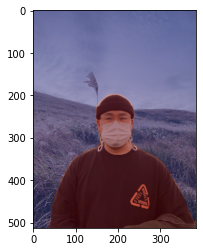

In [ ]:
def MakeMask(img_resized2, seg_map2, label):

    img_show = img_resized2.copy()
    seg_map2 = np.where(seg_map2 == label, label, 0) # 예측 중 사람만 추출
    img_mask = seg_map2 * (255/seg_map2.max()) # 255 normalization

    #cv2에 적용하기 위해서 type변경
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    #마스크와 원본이미지 더해줘서 하기
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_mask

mask = MakeMask(img_resized, seg_map, 15)

## 3. 세그멘테이션 결과를 원래 크기로 복원

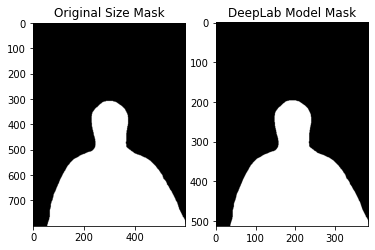

In [ ]:
#cv2.INTER_LINEAR 정확히 확대하기 위해서 이용
img_mask_up = cv2.resize(mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

#128 임계값설정하고 128이하값은 0, 이상은 255
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)


ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 4. 배경 흐리게 하기

>> 1. 배경을 흐리게 만듭니다. blur()함수를 이용

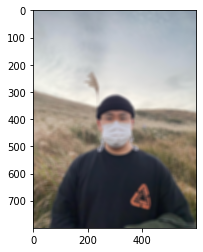

In [ ]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

>> 2. 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출 

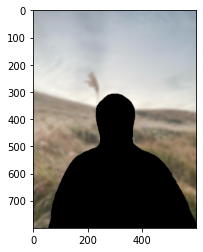

In [ ]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

#bitwise_not 함수이용해서 이미지 반전하기 배경은 255 / 사람은 0으로 됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 흐린 배경(및 다른 배경)과 원본 영상 합성

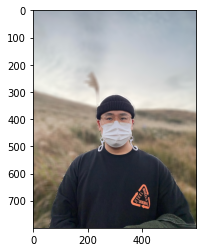

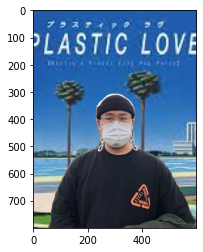

In [ ]:
# img_orig_blur 변수 흐린배경
# img_back 변수 이미지 배경

def BlurOrIm(back):

    img_concat = np.where(img_mask_color==255, img_orig, back)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

BlurOrIm(img_orig_blur)
BlurOrIm(img_back)

## 6. 고양이의 경우

In [ ]:
img_resized, seg_map = InputNetwork(img_cat)

(800, 600, 3) (513, 384, 3) 8





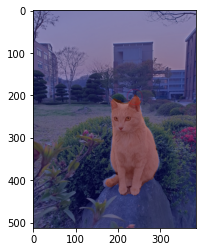

In [ ]:
mask = MakeMask(img_resized, seg_map, 8)

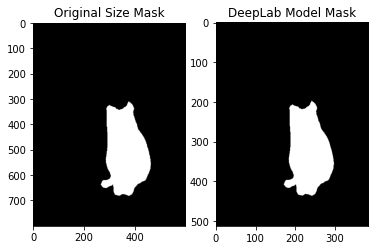

In [ ]:
#cv2.INTER_LINEAR 정확히 확대하기 위해서 이용
img_mask_up = cv2.resize(mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

#128 임계값설정하고 128이하값은 0, 이상은 255
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)


ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

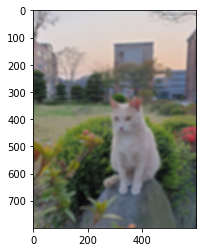

In [ ]:
img_cat_blur = cv2.blur(img_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

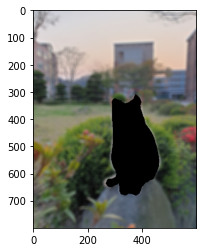

In [ ]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

#bitwise_not 함수이용해서 이미지 반전하기 배경은 255 / 사람은 0으로 됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

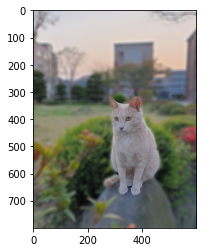

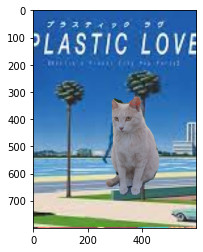

In [ ]:
# img_orig_blur 변수 흐린배경
# img_back 변수 이미지 배경

def BlurOrIm(back):

    img_concat = np.where(img_mask_color==255, img_cat, back)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

BlurOrIm(img_cat_blur)
BlurOrIm(img_back)

## 7. 다른 합성

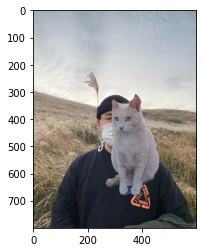

In [ ]:
def BlurOrIm(back):

    img_concat = np.where(img_mask_color==255, img_cat, back)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

BlurOrIm(img_orig)

# 2. 사진에서 문제점찾기

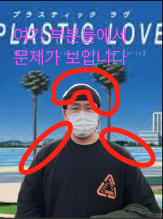

# 3. 해결 방법 제안해보기

<위 부분에서> 문제는 정확도가 1.00으로 매우 섬세하게 구현하기는 힘들다 

해결하기 위해서는 <첫번째> 3D깊이 카메라 기술을 이용하면 해결할 수 있다. 그 이유는 우선 "아웃포커싱 효과"는 피사체와 배경간 필름에 영사되는 "초점의 차이"를 이용해서 심도를 표현하기 때문이다.   

하지만 조리개 등을 조절할 수없는 dslr이 아닌 카메라는 <두번째> "3D깊이 카메라기술"을 이용해서 픽셀을 "깊이정보"까지 습득할 수 있게 되었다. 방식은 1. 스테레오방식 2. Tof방식 3. 구조화된 패턴방식으로 나누어진다다. 스테레오방식을 비추어보면 이른바 인물사진이라 기능을 제공하는 스마트폰은 카메라렌즈가 2개인데 그 이유가 이해된다

그 외에도 라이다 깊이 센서 등을 이용할수 있다 그러나 이러한 것들은 값이 비싸고, 늘 이용할수 있는것도 아니다. 따라서 <세번째>딥러닝 모델을 이용한다. 모델은 이미지의 깊이를 예측하고 이미지를 순차적으로 훈련받는다.
 
이러한 능력은 자율주행연구에도 마찬가지로 쓰일 수있다.



# 4. 회고

### 1. 과정
 (1). 모듈화 관련   
 사람사진 외에 고양이 사진을 blur처리한 것을 넣으려고하면 동일한 소스코드로 고양이 이미지에 대해서 한번 더 해야하는 점이 있다. 때문에 가급적 중복된 소스코드를 없애기위해서 몇 과정을 함수화 시켜 모듈화 했는데 생각보다 이미지 객체와 관련해서 의도대로 되지않아서 일부만 성공했다.


 (2). 배경이미지 관련   
 blur외 다른 배경이미지를 넣으려고 하면 그 배경이미지도 원래의 사진과 동일한 size이어야한다. 이것을 간과한채 배경을 넣어서서 오류가 발생하기도 했다. 

 (3). 인터프리터터상 특징관련   
  인터프리터는 1줄마다 실행하는 것으로서, 주의해야할 점을 알게되었다. 예컨데 변수값등에 대한 업데이트 문제이다. 변수값이 한번 잘못지정되면 다시 상단부터 실행하면서 해야하고, 여기서 좀 더 꼬여있다고 생각되면 아예 다시시작 & 전체 실행이 필요함을 알게되었다.


###  2. 배운점
  인물사진 만들기에서 머신러닝으로 접근하는 것이 결국 원본의 한장의 사진을 두장으로 나누어서, 다시 합성하는 방식으로 접근한다는 것을 알게되었다. 그 외에도 최근 다양한 기술로 이어지고 있고, 심지어 이러한 기술은 자율주행자동차의 기술로 연결된다는 것을 알게되었다.


### 3. 마치며   
 여러사진들을 언제든지 적용할 수 있는 모듈화를 다음 version에는 시도해보고 싶다.